<a href="https://colab.research.google.com/github/Tucker6742/CNN-sex-and-gender/blob/main/RELU_Best_Ejoyer_of_CNN_Sex_and_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle           

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/kaggle.json" ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:12<00:00, 37.8MB/s]
100% 331M/331M [00:12<00:00, 28.8MB/s]


In [ ]:
!unzip -qq /content/utkface-new.zip -d /content/file

$\huge\text{Import library}$


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random

In [ ]:
import tensorflow as tf
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K


In [ ]:
base_path = "/content/file/UTKFace/"
files = os.listdir(base_path)
size = len(files)

$\huge\text{Pre processing data}$


In [ ]:
# Preprocessing
shape = 70
images = []
ages = []
genders = []
for items in files:
    image = cv2.imread(base_path+items, 0)
    image = cv2.resize(image, dsize=(shape, shape))
    image = image.reshape((image.shape[0], image.shape[1], 1))
    images.append(image)
    split_var = items.split('_')
    ages.append(int(split_var[0]))
    genders.append(int(split_var[1]))



In [ ]:
# Encode age to 20 parts
def age_group(age):
    return min(age//5, 19)


In [ ]:
# Feature scaling 
target = np.zeros((size, 2), dtype = 'float64')
feature = np.zeros((size, shape, shape, 1), dtype = 'float64')

# Save a copy of the datatset
for i in range (size):
    target[i, 0] = ages[i]
    target[i, 1] = genders[i]
    feature[i] = images[i]
feature = feature/255 # Scaling the image

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Split dataset into train and test (80 : 20)
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, shuffle  = True)

print("Samples in Training:",x_train.shape)
print("Samples in Testing:",x_test.shape)

# Encode the age in the train set to 20 parts
for i in range(len(y_train)):
    y_train[i][0] = age_group(y_train[i][0])/20 # Scaling the age parts

# Define the age set and gender set in train set 
age_y_train = y_train[:, 0]
gender_y_train = y_train[:, 1]




Samples in Training: (18966, 70, 70, 1)
Samples in Testing: (4742, 70, 70, 1)


$\huge\text{Make model}$

In [ ]:
def img_cnn(drop_rate = 0):
	inputs = Input(shape=(shape,shape,1))
 
	# Doing convolution of the image
	conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
	pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
 
	conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(pool1)
	pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
 
	conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool2)
	pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
 
	conv4 = Conv2D(256, kernel_size=(3, 3),activation='relu')(pool3)
	pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
 
	conv5 = Conv2D(512, kernel_size=(3, 3),activation='relu')(pool4)
	pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
 
	x = Dropout(0.25)(pool5)
	flat = Flatten()(x)
	return inputs, flat

def modeling(flat, drop_rate = 0):

	# Making neural network
	# Age model
	dropout = Dropout(drop_rate)
	age_model = Dense(512, activation='relu')(flat)
	age_model = dropout(age_model)
	age_model = Dense(256, activation='relu')(age_model)
	age_model = dropout(age_model)
	age_model = Dense(128, activation='relu')(age_model)
	age_model = dropout(age_model)
	age_model = Dense(64, activation='relu')(age_model)
	age_model = dropout(age_model)
	age_model = Dense(32, activation='relu')(age_model)
	age_model = dropout(age_model)
	age_model = Dense(1, activation='relu')(age_model)
 
	# Gender model
	dropout = Dropout(drop_rate)
	gender_model = Dense(128, activation='relu')(flat)
	gender_model = dropout(gender_model)
	gender_model = Dense(64, activation='relu')(gender_model)
	gender_model = dropout(gender_model)
	gender_model = Dense(32, activation='relu')(gender_model)
	gender_model = dropout(gender_model)
	gender_model = Dense(16, activation='relu')(gender_model)
	gender_model = dropout(gender_model)
	gender_model = Dense(8, activation='relu')(gender_model)
	gender_model = dropout(gender_model)
	gender_model = Dense(1, activation='sigmoid')(gender_model)
	return age_model, gender_model

In [ ]:
# CNN the image
push, pull = img_cnn(0.5)

# Age and gender model
age_model, gender_model = modeling(pull, 0.25)

# Merge model
model = Model(inputs = push, outputs = [age_model, gender_model])
model.compile(optimizer = 'adam', loss =['mse', 'binary_crossentropy'],metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 70, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 68, 68, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 34, 34, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

$\huge\text{Train}$

In [ ]:
def own_cnn(log, EPOCHS, check, train_index, test_index):
    from keras.callbacks import CSVLogger
    # Use k-fold to split the train set into train and validate
    X_train = x_train[train_index]
    Age_Y_train = age_y_train[train_index]
    Gender_Y_train = gender_y_train[train_index]

    X_test = x_train[test_index]
    Age_Y_test = age_y_train[test_index]
    Gender_Y_test = gender_y_train[test_index]

    # Create log and fit the train
    logger = CSVLogger(f'/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Logs/relu model fold {log}.log', separator=',', append=check)
    M = model.fit(X_train,[Age_Y_train, Gender_Y_train], validation_data = (X_test, [Age_Y_test, Gender_Y_test]), epochs = EPOCHS, callbacks=[logger], batch_size = BATCH_SIZE, shuffle = True) 

    model.save(f'/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Models/model.h5') 

    

In [ ]:
# Here is to save the train and test index after using kfold
train_indexes = []
test_indexes = []

In [ ]:
c = input("Train from the last epoch? (Y/N): ")

if c == 'N':

    kf = KFold(n_splits = 10, random_state = 42, shuffle = True) 
    log = 0 # To keep track of the index of trained model 

    for j in range(2): # Train 20 times
        # define training hyperparameters
        BATCH_SIZE = 25
        EPOCHS = 15

        for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
            if i == 9:
                EPOCHS = 2 # The last train in 10 folds will train with 2 epochs to prevent overfitting
            log = log+1

		    # Keep the train and test index to train from the last model
            train_indexes.append(train_index)
            test_indexes.append(test_index)

                             
            # train 
            own_cnn(log, EPOCHS , False, train_index, test_index)
            EPOCHS -= 1 # Decrease one epoch after training each fold to prevent overfitting
        
else:
    log = 9 #index of last log save in drive
    check = False # Check if last log index >= 10
    for j in range(2): # Train 20 times

        if log >= 10 and check == False: # If last log index >= 10
            log = log - 10
            check = True
            continue # Skip first iteration if last log index >= 10 

        elif log >= 10 and check == True:
            log = log - 10 # To train after iterating through 10 folds in the first iteration

        # define training hyperparameters
        BATCH_SIZE = 25
        EPOCHS = 15
        for i in range(log, 10, 1): 
            if i == 9:
                EPOCHS = 2
            log = log + 1
    
            # train 
            own_cnn(log, EPOCHS, True, train_indexes[log], test_indexes[log])
            EPOCHS -= 1 # Decrease one epoch after training each fold to prevent overfitting


Train from the last epoch? (Y/N): N
Epoch 1/15
683/683 [==============================] - 9s 13ms/step - loss: 0.1319 - dense_5_loss: 0.0141 - dense_11_loss: 0.1178 - dense_5_accuracy: 0.0925 - dense_11_accuracy: 0.9537 - val_loss: 0.0809 - val_dense_5_loss: 0.0114 - val_dense_11_loss: 0.0694 - val_dense_5_accuracy: 0.0933 - val_dense_11_accuracy: 0.9705
Epoch 2/15
683/683 [==============================] - 8s 12ms/step - loss: 0.1212 - dense_5_loss: 0.0138 - dense_11_loss: 0.1074 - dense_5_accuracy: 0.0926 - dense_11_accuracy: 0.9576 - val_loss: 0.0834 - val_dense_5_loss: 0.0108 - val_dense_11_loss: 0.0726 - val_dense_5_accuracy: 0.0933 - val_dense_11_accuracy: 0.9726
Epoch 3/15
683/683 [==============================] - 9s 13ms/step - loss: 0.1162 - dense_5_loss: 0.0138 - dense_11_loss: 0.1024 - dense_5_accuracy: 0.0926 - dense_11_accuracy: 0.9583 - val_loss: 0.0759 - val_dense_5_loss: 0.0106 - val_dense_11_loss: 0.0653 - val_dense_5_accuracy: 0.0933 - val_dense_11_accuracy: 0.9758
E

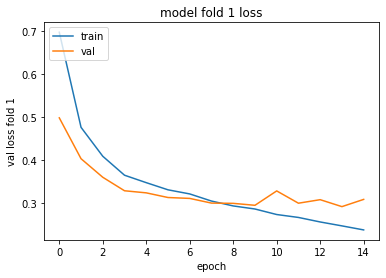

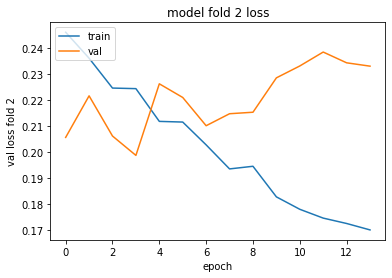

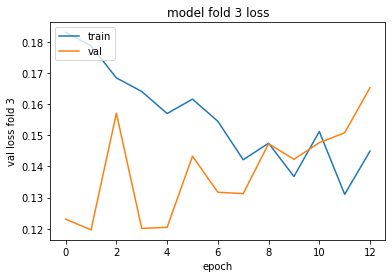

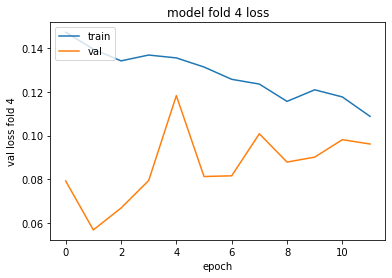

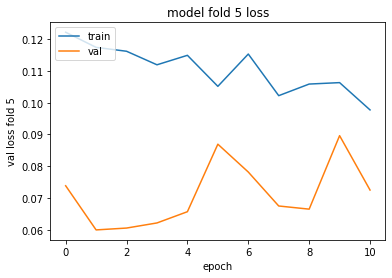

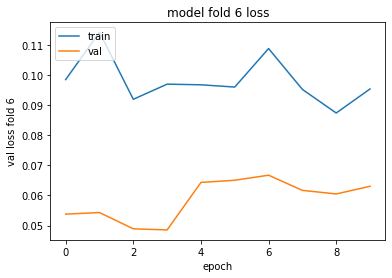

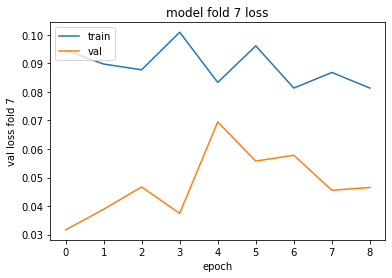

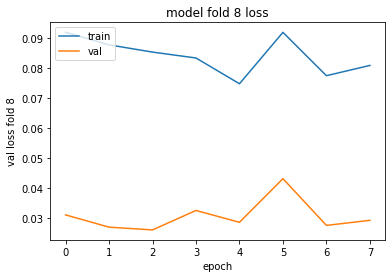

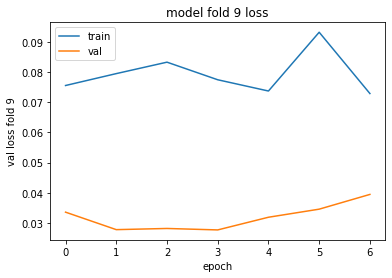

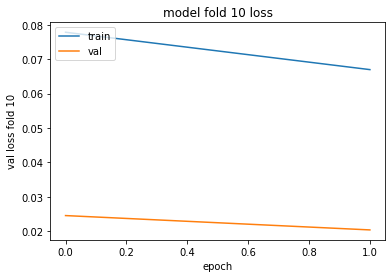

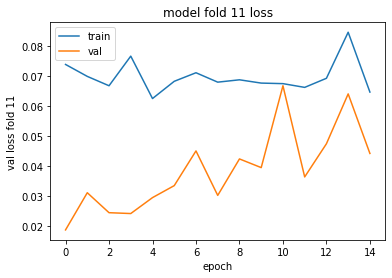

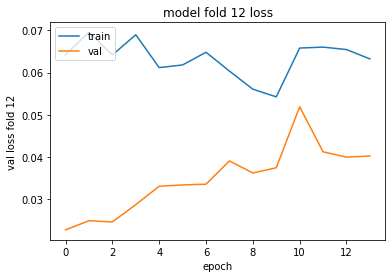

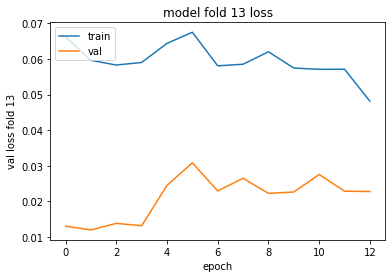

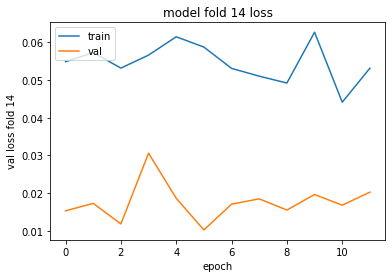

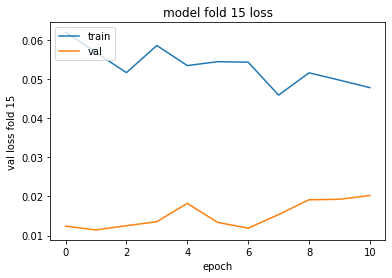

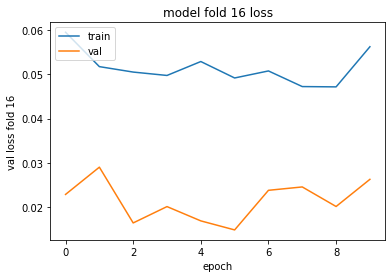

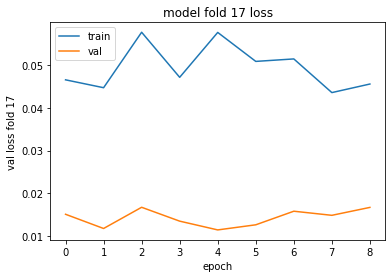

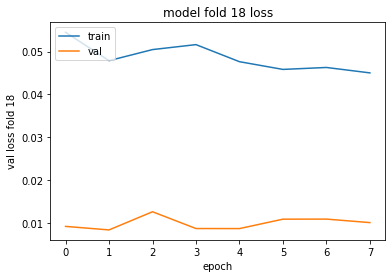

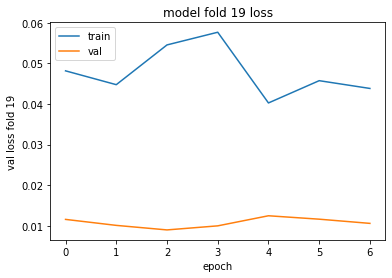

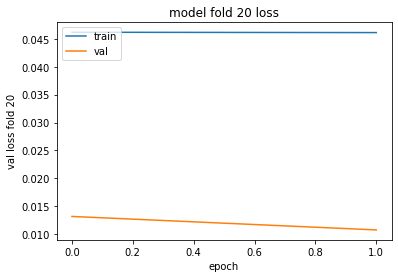

In [ ]:
%matplotlib inline
plt.close('all')
for i in range(20):
    # Get the log files
    history = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/Relu logs/relu model fold {i+1}.log')
    
    # Plot
    plt.plot(history['epoch'], history['loss'])
    plt.plot(history['epoch'], history['val_loss'])
    plt.title(f'model fold {i + 1} loss')
    plt.ylabel(f'val loss fold {i + 1}')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

$\huge\text{Test}$

In [ ]:
# This is the best model of us
# model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/Bản sao của model fold 5.h5')

# Load the trained model
model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Models/model.h5')

In [ ]:
def get_age(d):
    # Get the predicted value
    d = d * 20

    # If predicted values in the encoded age
    if 0 <= d <= 19:

        if d < 0.5: # The values predicted for child from 0 - 4 years old 
            return "0 - 4"

        if d > int(d) + 0.5: # If surely this age part
            return f"{int(d*5)} - {int(d*5+4)}"

        else: # If not sure then we return the age part right before
            return f"{int((d - 1) * 5)} - {int((d - 1) * 5 + 4)}"

    # If predicted values not in th encoded age
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male" # If predicted values < 0.5 (because we use sigmoid to guess gender)
    else: return "Female"

def get_result(sample):
    sample = sample/255 # Scaling the input
    val = model.predict(np.array([sample])) # Get the predicted values

    # Same as get_age() but here I want to get the values, not string
    age_val = val[0] * 20
    if age_val > int(age_val) + 0.5:
        age_val = int(age_val) + 1
    else:
        age_val = int(age_val) 

    # Get the prediction from the predicted values
    age = get_age(val[0])
    gender = get_gender(val[1])

    print(val)
    print("Predicted Gender:",gender,"Predicted Age:",age)
    return age, gender, age_val
    
    


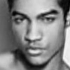

Actual Gender: Male
Age: 26
1/1 [==============================] - 0s 300ms/step
[array([[0.23543137]], dtype=float32), array([[0.]], dtype=float32)]
Predicted Gender: Male Predicted Age: 23 - 27


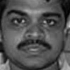

Actual Gender: Male
Age: 26
1/1 [==============================] - 0s 25ms/step
[array([[0.3219857]], dtype=float32), array([[0.]], dtype=float32)]
Predicted Gender: Male Predicted Age: 27 - 31


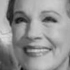

Actual Gender: Female
Age: 60
1/1 [==============================] - 0s 24ms/step
[array([[0.51834965]], dtype=float32), array([[1.]], dtype=float32)]
Predicted Gender: Female Predicted Age: 46 - 50


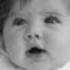

Actual Gender: Female
Age: 1
1/1 [==============================] - 0s 29ms/step
[array([[0.]], dtype=float32), array([[1.]], dtype=float32)]
Predicted Gender: Female Predicted Age: 0 - 4


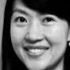

Actual Gender: Female
Age: 29
1/1 [==============================] - 0s 25ms/step
[array([[0.23577869]], dtype=float32), array([[1.]], dtype=float32)]
Predicted Gender: Female Predicted Age: 23 - 27


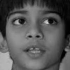

Actual Gender: Male
Age: 12
1/1 [==============================] - 0s 24ms/step
[array([[0.23543137]], dtype=float32), array([[6.106676e-24]], dtype=float32)]
Predicted Gender: Male Predicted Age: 23 - 27


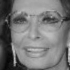

Actual Gender: Female
Age: 65
1/1 [==============================] - 0s 22ms/step
[array([[0.5421427]], dtype=float32), array([[1.]], dtype=float32)]
Predicted Gender: Female Predicted Age: 54 - 58


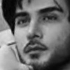

Actual Gender: Male
Age: 26
1/1 [==============================] - 0s 24ms/step
[array([[0.25951782]], dtype=float32), array([[0.]], dtype=float32)]
Predicted Gender: Male Predicted Age: 20 - 24


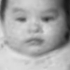

Actual Gender: Female
Age: 1
1/1 [==============================] - 0s 24ms/step
[array([[0.]], dtype=float32), array([[0.9959991]], dtype=float32)]
Predicted Gender: Female Predicted Age: 0 - 4


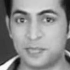

Actual Gender: Male
Age: 23
1/1 [==============================] - 0s 24ms/step
[array([[0.23543137]], dtype=float32), array([[1.3754351e-25]], dtype=float32)]
Predicted Gender: Male Predicted Age: 23 - 27


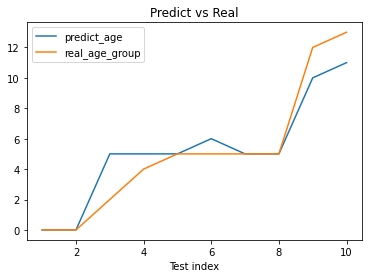

In [ ]:
import copy

n_test = 10 # Number of samples for quick test

# Here is to save the predict and real to summarize later
predict_age = []
real_age_group = []

# Random n_test tests
index = [random.randint(0, 18966) for i in range(n_test)]
for i in index:
    sample = images[i]
    cv2_imshow(sample)
    print("Actual Gender:",get_gender(genders[i]))
    print("Age:",ages[i])
    age, gender, age_val = get_result(sample)
    predict_age.append(age_val)
    real_age_group.append(age_group(ages[i]))

real = real_age_group.copy()
predict = predict_age.copy()

# Sort the list of real and predict for the plot to be more easily observed
real_age_group = np.array(real_age_group)
predict_age = np.array(predict_age)
predict_age = predict_age.reshape(n_test)

inds = real_age_group.argsort()
sorted_predict_age = predict_age[inds]
real_age_group.sort()

# Plot the real and predict line
%matplotlib inline
plt.close('all')
test = [i+1 for i in range(n_test)]
plt.plot(test, sorted_predict_age)
plt.plot(test, real_age_group)
plt.title("Predict vs Real")
plt.xlabel('Test index')
plt.legend(['predict_age', 'real_age_group'], loc='upper left')
plt.show()

In [ ]:
# Predict the test
# Same as quick test above

predict_age = []
real_age_group = []

for i in range(len(x_test)):
    # To show the testing picture
    sample = x_test[i]*255 
    cv2_imshow(sample)
    
    print("Actual Gender:",get_gender(y_test[i][1]))
    print("Age:",y_test[i][0])
    age, gender, age_val = get_result(sample)
    predict_age.append(age_val)
    real_age_group.append(age_group(y_test[i][0]))

1/1 [==============================] - 0s 29ms/step


In [ ]:
# Same as quick test
real = real_age_group.copy()
predict = predict_age.copy()

real_age_group = np.array(real_age_group)
predict_age = np.array(predict_age)
predict_age = predict_age.reshape(len(x_test))

inds = real_age_group.argsort()
sorted_predict_age = predict_age[inds]
real_age_group.sort()

$\huge\text{Summary}$

In [ ]:
# Put the real and predict in dataframe
df = pd.DataFrame([sorted_predict_age, real_age_group])
df = df.T
df.rename(columns = {0:"Predict",1:"Real"},inplace=True)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/test relu 1.csv')

Predict mean:  6.294601433994095
Real mean:  6.336988612399831
Predict variance:  10.701422019976851
Real variance:  15.85435397540288


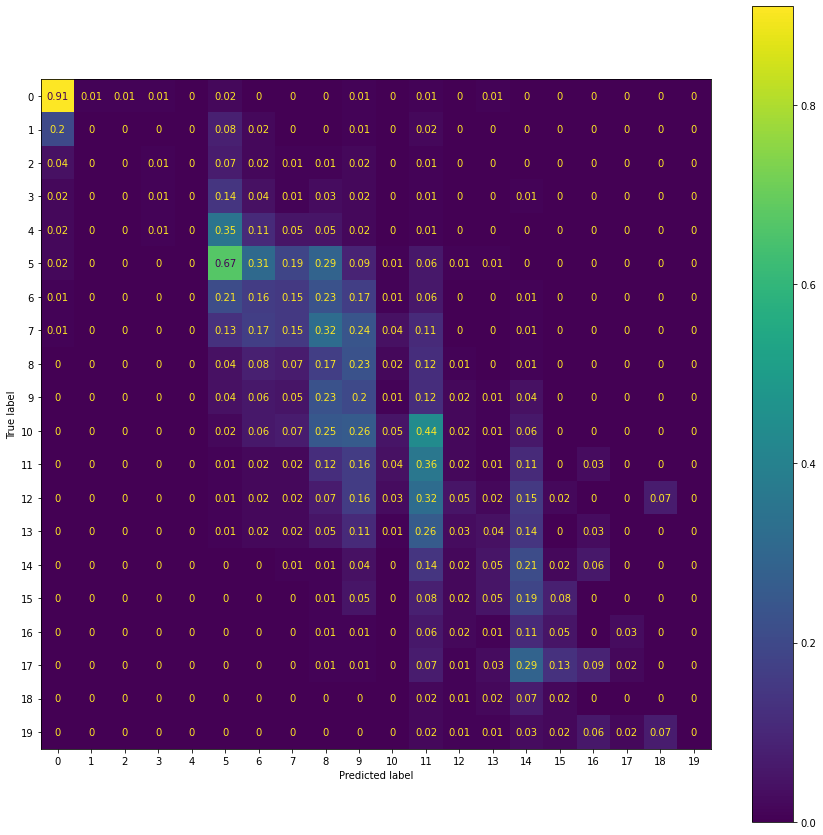

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CNN Sex and Age/Checkpoints/test relu 1.csv')
# Get some statistical analysis
print('Predict mean: ', df['Predict'].mean())
print('Real mean: ', df['Real'].mean())
print('Predict variance: ', df['Predict'].var())
print('Real variance: ', df['Real'].var())

# Plot the confusion matrix
classes = [i for i in range(20)]
cm = confusion_matrix(df['Real'], df['Predict'], labels=classes)
cm = cm/cm.astype(float).sum(axis=1)
cm = cm.round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=classes)

disp.plot()
plt.rcParams['figure.figsize'] = (15, 15) # Set the size of confusion matrix
plt.show()

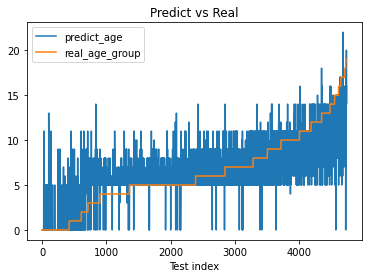

In [ ]:
# Plot the real and predict line
%matplotlib inline
plt.close('all')
test = [i+1 for i in range(len(df))]
plt.plot(test, df['Predict'])
plt.plot(test, df['Real'])
plt.title("Predict vs Real")
plt.xlabel('Test index')
plt.legend(['predict_age',  'real_age_group'], loc='upper left')
plt.rcParams['figure.figsize'] = [60, 60]
plt.show()

In [ ]:
# Accuracy
accuracy = 0
for i in range(len(df)):
    if df['Predict'][i] == df['Real'][i]:
        accuracy = accuracy + 1
accuracy = accuracy/len(df['Real'])
print('Accuracy: ', accuracy)

Accuracy:  0.29628848587094053
